In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from pytorchcv.model_provider import get_model
from torchsummary import summary
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from classes import class_names

In [2]:
net = get_model("zfnet", pretrained=True)
summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 110, 110]          14,208
              ReLU-2         [-1, 96, 110, 110]               0
          AlexConv-3         [-1, 96, 110, 110]               0
         MaxPool2d-4           [-1, 96, 55, 55]               0
            Conv2d-5          [-1, 256, 26, 26]         614,656
              ReLU-6          [-1, 256, 26, 26]               0
          AlexConv-7          [-1, 256, 26, 26]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
         AlexConv-11          [-1, 384, 13, 13]               0
           Conv2d-12          [-1, 384, 13, 13]       1,327,488
             ReLU-13          [-1, 384, 13, 13]               0
         AlexConv-14          [-1, 384,

In [3]:
class CustomDataset(Dataset):
    
    def __init__(self, transform = None):
        
        self.transform = transform
        self.imgs = []
        self.imgsToDisplay = []
        
        current_dir = os.getcwd()
        image_dir = os.path.join(current_dir, 'img/')
        img_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')]
    
        for img in img_files:
            # Read image.
            img = cv2.imread(img)
            
            self.imgsToDisplay.append(img)
            
            # Apply transformations.
            if self.transform is not None:
                img = self.transform(img)
                
            self.imgs.append(img)
            
    def __getitem__(self, index):    
        return self.imgs[index]
        
    def __len__(self):
        return len(self.imgs)


In [6]:
transformations = transforms.Compose([transforms.ToPILImage(), 
                                      transforms.Resize((227,227)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                           std = [0.229, 0.224, 0.225]),
                                     ])

custom_dataset = CustomDataset(transform=transformations)
test_loader = DataLoader(dataset=custom_dataset,
                         batch_size=1)

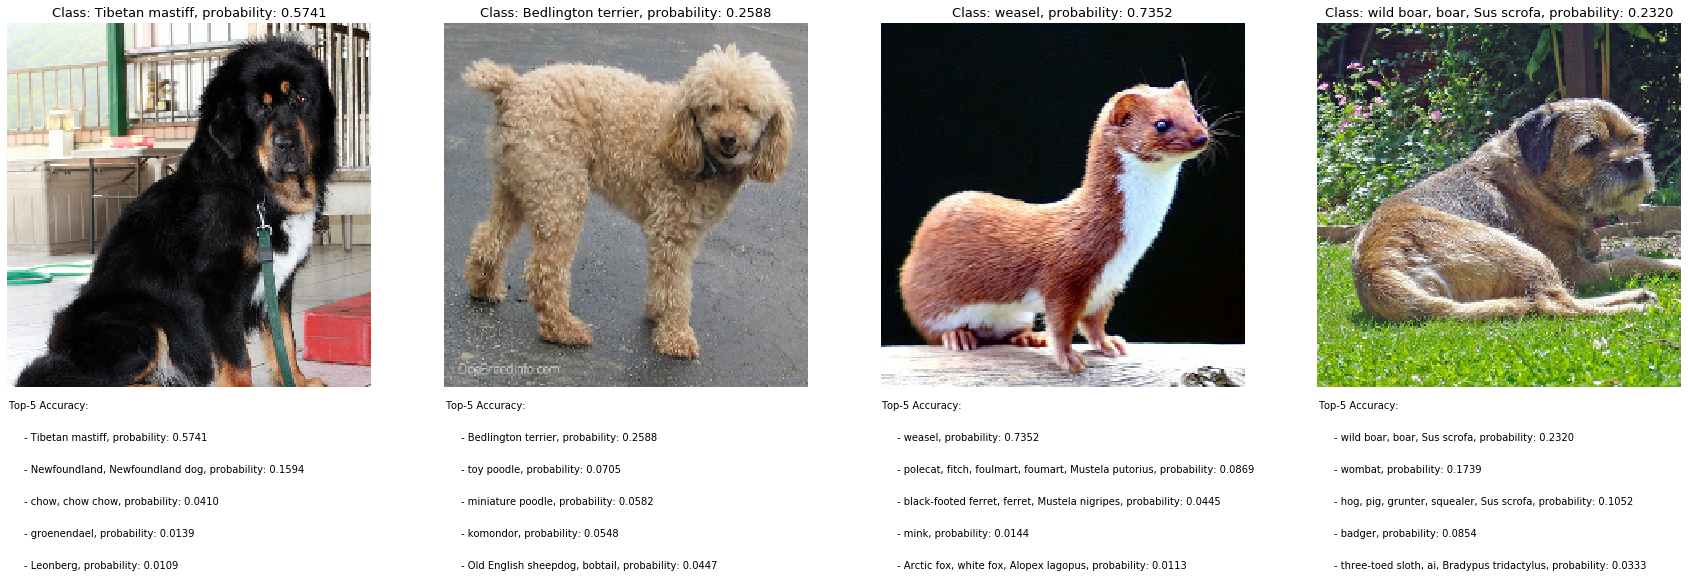

In [7]:
fig2 = plt.figure(figsize=(30,10))

with torch.no_grad():
    
    for i, image in enumerate(test_loader):
        probs = torch.nn.Softmax(dim=-1)(net(image))
        
        probability, class_idx = torch.max(probs, 1)
        class_name = class_names[class_idx]
         
        fig2.add_subplot(1,4,i+1)
        
        plt.imshow(cv2.cvtColor(custom_dataset.imgsToDisplay[i], cv2.COLOR_BGR2RGB))
        plt.title("Class: " + class_name + ", probability: %.4f" % probability, fontsize=13)
        plt.axis('off')

        plt.text(0, 240, 'Top-5 Accuracy:')
        x, y = 10, 260
        for idx in np.argsort(probs.numpy())[0][-5::][::-1]:
            plt.text(x, y, s ='- {}, probability: {:.4f}'.format(class_names[idx], probs[0, idx]), fontsize=10)
            y += 20
        print()